# DeepDMD

## Import Modules

In [1]:
# Standard Libraries
import os
import time
import numpy as np
import tensorflow as tf

tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')
print("[INFO] Tensorflow version: ", tf.__version__)
# print("[INFO] Eager mode: ", tf.executing_eagerly()) # For easy reset of notebook state.

[INFO] Tensorflow version:  2.4.1


In [2]:
# Custom Library
import sys
sys.path.append('../../')

from proxy_apps.data_handler import grid_network
from proxy_apps.apps.timeseries_prediction import deepDMD
from proxy_apps.plot_lib.simple_plots import eigen_plot, validation_plot, heatmap_matplotlib

In [3]:
N_EPOCHS = 1
timing_dict = dict()

## Data Loading and Preprocessing
The input data for the model should be in the form of array. The output array (Y) will have same number of features as the input array (X) but Y would be a time shifted version of the X. In the case of DeepDMD, the shift was equal to 1. In the original application, the data is not sequential and rather restructured using rolling window.

In [4]:
scenario_dir = '../../../../data/TrainingDataIEEE68bus'
print('[INFO]: Loading the datasets from the directory:', scenario_dir)
dir_list = os.listdir(scenario_dir)

# Indicate the scenario range
Dataset = dict()
print('[INFO]: Loading data for %d scenarios ...' % len(dir_list))

[INFO]: Loading the datasets from the directory: ../../../../data/TrainingDataIEEE68bus
[INFO]: Loading data for 30 scenarios ...


#### Data Loading

In [5]:
# step-1: load data
l_start = time.time()
scenario_data = []
count = 0
for s_dir in dir_list:
    if s_dir.find('scenario') == -1:
        continue
    dataset = grid_network.TransientDataset('%s/%s/' % (scenario_dir, s_dir))
    original_shape = np.concatenate((dataset.F, dataset.Vm), axis=1).shape
    scenario_data.append(np.concatenate((dataset.F[:1000,:], dataset.Vm[:1000,:]), axis=1))
    count += 1
    if count % 50 == 0:
        print('[INFO]: Loaded %d/%d scenarios ...' % (count, len(dir_list)))
l_stop = time.time()
print('[INFO]: Time taken for loading datasets:', l_stop - l_start, 'seconds')
print('[INFO]: Total number of scenarios loaded:', len(scenario_data))
print('[INFO]: Shape of each scenario original: ', original_shape)
print('[INFO]: Shape of each scenario loaded: ', scenario_data[0].shape)
print('[INFO]: Done ...')

timing_dict['load_data'] = (l_stop - l_start)/60

[INFO]: Time taken for loading datasets: 11.577550172805786 seconds
[INFO]: Total number of scenarios loaded: 30
[INFO]: Shape of each scenario original:  (1400, 136)
[INFO]: Shape of each scenario loaded:  (1000, 136)
[INFO]: Done ...


#### Create Data

In [6]:
# step-2: create data
i_start = time.time()
X_data = [] # Original data
Y_data = [] # 1 time-shifted data
U_data = [] # 2 time-shifted data
V_data = [] # 3 time-shifted data
whole_data = [] # Complete data 
Yp = [] # For analytical calculations
Yf = [] # For analytical calculations
count  = 0
ds  = 1
M = 2 # signifies number of time-shifts
N = 3 # signifies number of time-shifts

for dataset in scenario_data:    
    dataset_size = dataset.shape[0]
    whole_data.append(dataset)      
    Yp.append(dataset[:-1,:])
    Yf.append(dataset[1:,:])
    count += 1
    if count % 50 == 0:
        print('Done processing %d/%d datasets ...' % (count, len(scenario_data)))
    window_size = 800 # length of moving window
    shift_size  = 10 # separation between two moving windows
    i = 0
    while (i*shift_size+window_size+M+N) <= dataset_size:
        X_indices = range(i*shift_size, i*shift_size + window_size,ds)        
        Y_indices = range(i*shift_size+1, i*shift_size + window_size+1,ds)               
        U_indices = range(i*shift_size+M, i*shift_size + window_size+M,ds)               
        V_indices = range(i*shift_size+N, i*shift_size + window_size+N,ds)   
        if count < 0:
            print(X_indices)
            print(Y_indices)
            print(U_indices)
            print(V_indices)        

        i = i + 1
        X_data.append(dataset[X_indices])
        Y_data.append(dataset[Y_indices])
        U_data.append(dataset[U_indices])
        V_data.append(dataset[V_indices])

i_stop = time.time()
print('[INFO]: Time taken for creating X datasets:', i_stop - i_start, 'seconds')
print('[INFO]: Original dataset size:', dataset_size)
print('[INFO]: Chosen dataset size:', window_size)
print('[INFO]: Length of X_data: ', len(X_data))
print('[INFO]: Length of each window after down sampling: ', X_data[0].shape)

timing_dict['create_data'] = (i_stop - i_start)/60

[INFO]: Time taken for creating X datasets: 4.359763860702515 seconds
[INFO]: Original dataset size: 1000
[INFO]: Chosen dataset size: 800
[INFO]: Length of X_data:  600
[INFO]: Length of each window after down sampling:  (800, 136)


#### Data Normalization

In [8]:
# step-3: normalization
n_start = time.time()
Normalization = 1
scale_factor = 2*np.pi 

X_array = np.asarray(X_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
Y_array = np.asarray(Y_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
U_array = np.asarray(U_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
V_array = np.asarray(V_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
whole_data_array = np.asarray(whole_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
Yp_array = np.asarray(Yp).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
Yf_array = np.asarray(Yf).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
print("[INFO]: whole_data_array shape:", whole_data_array.shape)
print('[INFO]: Yp_array shape: ', Yp_array.shape)
print('[INFO]: Yf_array shape: ', Yf_array.shape)
print('[INFO]: X_array shape: ', X_array.shape)
print('[INFO]: Y_array shape: ', Y_array.shape)
print('[INFO]: U_array shape: ', U_array.shape)
print('[INFO]: V_array shape: ', V_array.shape)

if Normalization:  
    X_array_old  = X_array
    Y_array_old  = Y_array
    U_array_old  = U_array
    V_array_old  = V_array
    Yp_array_old = Yp_array
    Yf_array_old = Yf_array
    X_array      = np.concatenate((scale_factor*(X_array_old[:,:68] - 60), 10*(X_array_old[:,68:] - 1)), axis = 1) 
    Y_array      = np.concatenate((scale_factor*(Y_array_old[:,:68] - 60), 10*(Y_array_old[:,68:] - 1)), axis = 1) 
    U_array      = np.concatenate((scale_factor*(U_array_old[:,:68] - 60), 10*(U_array_old[:,68:] - 1)), axis = 1) 
    V_array      = np.concatenate((scale_factor*(V_array_old[:,:68] - 60), 10*(V_array_old[:,68:] - 1)), axis = 1) 
    Yp_array     = np.concatenate((scale_factor*(Yp_array_old[:,:68] - 60), 10*(Yp_array_old[:,68:] - 1)), axis = 1)
    Yf_array     = np.concatenate((scale_factor*(Yf_array_old[:,:68] - 60), 10*(Yf_array_old[:,68:] - 1)), axis = 1)    
        
n_stop = time.time()
print('[INFO]: Time taken for normalization:', n_stop - n_start, 'seconds')

[INFO]: whole_data_array shape: (30000, 136)
[INFO]: Yp_array shape:  (29970, 136)
[INFO]: Yf_array shape:  (29970, 136)
[INFO]: X_array shape:  (480000, 136)
[INFO]: Y_array shape:  (480000, 136)
[INFO]: U_array shape:  (480000, 136)
[INFO]: V_array shape:  (480000, 136)
[INFO]: Time taken for normalization: 42.69359278678894 seconds


In [9]:
Yp_array.shape

(29970, 136)

In [10]:
X_array[0, :20]

array([-0.14165288, -0.03844356, -0.01614739, -0.02112808, -0.03753495,
       -0.03595576, -0.05122148, -0.05883799, -0.18163594, -0.01606364,
       -0.02258537, -0.01816804, -0.01371952, -0.00716514,  0.03021367,
        0.04639342,  0.02124267,  0.00693749,  0.0406679 ,  0.05210838])

## Data Modeling

In [11]:
tf.config.run_functions_eagerly(True)

In [12]:
class HyperParameters():
    def __init__(self, config):
        self.od = config['original_dim']
        self.h1 = config['hl_1_dim']
        self.h2 = config['hl_2_dim']
        self.h3 = config['hl_3_dim']
        self.h4 = config['hl_4_dim']
        ## hp.h5 = config['hl_5_dim']
        self.ld = config['latent_dim']
        self.rf = config['reg_factor']
        self.dr = config['dropout_prob']
        self.wr = config['weight_regularizer']
        self.br = config['bias_regularizer']
        self.ep = config['num_epochs']
        self.lr = config['learning_rate']
        self.bs = config['batch_size']
        self.vs = config['validation_split']

# Neural Network
class NeuralNetworkModel(tf.keras.Model): 
    def __init__(self, hp):
        super(NeuralNetworkModel, self).__init__()
        
        self.encoder = Encoder(hp)        
        
        # Define and randomly initialize the Koopman operator
        self.KO = tf.Variable(tf.random.normal(shape = (hp.ld+hp.od, hp.ld+hp.od), mean=0.0, stddev=0.05, 
                                                    dtype=tf.dtypes.float64, seed=123321, name='KoopmanOperator'),
                                                    trainable=True)
        self.rf = hp.rf 
        
    def call(self, inputs):       
        X        = inputs[0]
        Y        = inputs[1]   
        
        Psi_X    = self.encoder(X)
        Psi_Y    = self.encoder(Y)        
        
        PSI_X    = tf.concat([X, Psi_X], 1)
        PSI_Y    = tf.concat([Y, Psi_Y], 1) 
        
        # 1-time step evolution on observable space:
        K_PSI_X  = tf.matmul(PSI_X, self.KO) 
        
        # 1-step Koopman loss on observable space:        
        K_loss   = tf.norm(PSI_Y - K_PSI_X, axis = [0,1], ord = 'fro')
        
        # Regularization loss on Koopman operator:
        Reg_loss= tf.cast(tf.math.scalar_mul(self.rf,tf.norm(self.KO, axis = [0,1], ord = 'fro')), dtype = 'float64')        
        
        # Total loss:
        loss = K_loss + Reg_loss 
        
        self.add_loss(loss)
        return Psi_X, PSI_X, Psi_Y, PSI_Y, K_loss

class Encoder(tf.keras.layers.Layer):
    def __init__(self, hps):
        super(Encoder, self).__init__(dtype = 'float64', name = 'Encoder')
        self.input_layer   = DenseLayer(hps.h1, hps.od, 0.0, 0.0)
        self.hidden_layer1 = DenseLayer(hps.h2, hps.h1, hps.wr, hps.br)
        self.dropout_laye1 = tf.keras.layers.Dropout(hps.dr)
        self.hidden_layer2 = DenseLayer(hps.h3, hps.h2, hps.wr, hps.br)        
        self.dropout_laye2 = tf.keras.layers.Dropout(hps.dr)
        self.hidden_layer3 = DenseLayer(hps.h4, hps.h3, hps.wr, hps.br)
        self.dropout_laye3 = tf.keras.layers.Dropout(hps.dr)           
#         self.hidden_layer4 = DenseLayer(hps.h5, hps.h4, hps.wr, hps.br)
#         self.dropout_laye4 = layers.Dropout(hps.dr)             
        self.output_layer  = LinearLayer(hps.ld, hps.h4, hps.wr, hps.br)
        
    def call(self, input_data, training):
        fx = self.input_layer(input_data)        
        fx = self.hidden_layer1(fx)
        if training:
            fx = self.dropout_laye1(fx)     
        fx = self.hidden_layer2(fx)
        if training:
            fx = self.dropout_laye2(fx) 
        fx = self.hidden_layer3(fx)
        if training:
            fx = self.dropout_laye3(fx) 
#         fx = self.hidden_layer4(fx)
#         if training:
#             fx = self.dropout_laye4(fx)
        return self.output_layer(fx)    

class LinearLayer(tf.keras.layers.Layer):

    def __init__(self, units, input_dim, weights_regularizer, bias_regularizer):
        super(LinearLayer, self).__init__(dtype = 'float64')
        self.w = self.add_weight(shape = (input_dim, units), 
                                initializer = tf.keras.initializers.RandomUniform(
                                minval=-tf.cast(tf.math.sqrt(6/(input_dim+units)), dtype = 'float64'), 
                                maxval=tf.cast(tf.math.sqrt(6/(input_dim+units)), dtype = 'float64'), 
                                seed=16751),                                                                   
#                               regularizer = tf.keras.regularizers.l1(weights_regularizer), 
                                trainable = True)
        self.b = self.add_weight(shape = (units,),    
                                 initializer = tf.zeros_initializer(),
                                 regularizer = tf.keras.regularizers.l1(bias_regularizer),
                                 trainable = True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class DenseLayer(tf.keras.layers.Layer):

    def __init__(self, units, input_dim, weights_regularizer, bias_regularizer):
        super(DenseLayer, self).__init__(dtype = 'float64')
        self.w = self.add_weight(shape = (input_dim, units), 
                                 initializer = tf.keras.initializers.RandomUniform(
                                     minval=-tf.cast(tf.math.sqrt(6.0/(input_dim+units)), dtype = 'float64'),  
                                     maxval=tf.cast(tf.math.sqrt(6.0/(input_dim+units)) , dtype = 'float64'),  
                                     seed=16751), 
                                 regularizer = tf.keras.regularizers.l1(weights_regularizer), 
                                 trainable = True)
        self.b = self.add_weight(shape = (units,),    
                                 initializer = tf.zeros_initializer(),
                                 regularizer = tf.keras.regularizers.l1(bias_regularizer),
                                 trainable = True)

    def call(self, inputs):
        x = tf.matmul(inputs, self.w) + self.b
        return tf.nn.elu(x)

In [13]:
# Hyperparameters
hyper_param_dict = dict()
hyper_param_dict['original_dim']       = 136   # input data dimension
hyper_param_dict['hl_1_dim']           = 128   # Hidden layer dimension
hyper_param_dict['hl_2_dim']           = 128   # Hidden layer dimension
hyper_param_dict['hl_3_dim']           = 64   # Hidden layer dimension
hyper_param_dict['hl_4_dim']           = 64   # Hidden layer dimension
# hyper_param_dict['hl_5_dim']           = 64   # Hidden layer dimension
hyper_param_dict['latent_dim']         = 64 # Latent space dimension 
hyper_param_dict['reg_factor']         = 0 # regularization weight for Koopman
hyper_param_dict['dropout_prob']       = 0.005  # dropout rate [regularization between hidden layers]
hyper_param_dict['weight_regularizer'] = 0.001  # [L1] regularization weight for dense layer weights 
hyper_param_dict['bias_regularizer']   = 0    # [L1] regularization bias for dense layer biases
hyper_param_dict['num_epochs']         = 2  # Number of epochs 
hyper_param_dict['learning_rate']      = 5e-4 # learning rate for optimizer 
hyper_param_dict['validation_split']   = 0.25
hyper_param_dict['batch_size']         = 32

# Initialize Hyperparameters - we can keep it as a dict instead of creating a separate class
hp = deepDMD.HyperParameters(hyper_param_dict)

In [14]:
# Stopping criteria if the training loss doesn't go down by 1e-3
CallBack = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta = 1e-3, verbose = 1, mode='min', patience = 3, 
    baseline=None, restore_best_weights=True)
K_model = NeuralNetworkModel(hp)
K_model.compile(optimizer=tf.optimizers.Adagrad(hp.lr))
history = K_model.fit([X_array, Y_array], validation_split = hp.vs, batch_size = hp.bs, 
                   epochs=hp.ep, callbacks=[CallBack], shuffle = False)

C:\Users\jain432\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/2
11250/11250 [==============================] - 1011s 90ms/step - loss: 4.7748 - val_loss: 2.7804
Epoch 2/2
11250/11250 [==============================] - 8834s 785ms/step - loss: 2.9285 - val_loss: 2.5875


## Model Evaluation

Koopman loss: 28.9119
Psi_X shape: (29970, 64)
Psi_Y shape: (29970, 64)
PSI_X shape: (29970, 200)
PSI_X shape: (29970, 200)


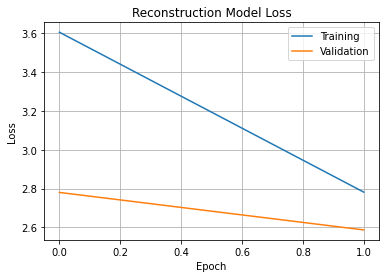

In [15]:
Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss = K_model([Yp_array, Yf_array], training=False)
print("Koopman loss: %.4f" %Kloss.numpy())

print('Psi_X shape:', Psi_X.numpy().shape)
print('Psi_Y shape:', Psi_Y.numpy().shape)
print('PSI_X shape:', PSI_X.numpy().shape)
print('PSI_X shape:', PSI_Y.numpy().shape)

# Plot training & validation loss values
validation_plot(history)

### Find the Koopman operator and check its eigenvalues and sparsity structure 

[INFO]: Shape of Koopman operator (200, 200)
[INFO]: Norm of Koopman operator 10.051882661446736
[INFO]: Trace of K_deepDMD: 5.06192093878663
[INFO]: One time-step error with K_deepDMD: 28.91191532667973


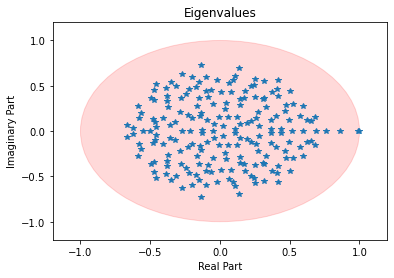

In [16]:
K_deepDMD = K_model.KO.numpy()

print('[INFO]: Shape of Koopman operator', K_deepDMD.shape)
print('[INFO]: Norm of Koopman operator', np.linalg.norm(K_deepDMD))
print('[INFO]: Trace of K_deepDMD:',np.trace(K_deepDMD))
print('[INFO]: One time-step error with K_deepDMD:', np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro'))

[eigenvaluesK, eigenvectorsK] = np.linalg.eig(K_deepDMD)
eigen_plot(eigenvaluesK.real, eigenvaluesK.imag)

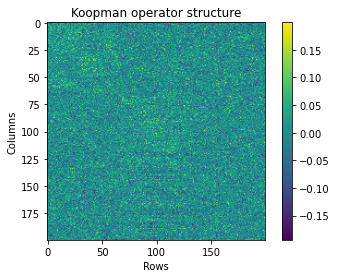

In [17]:
heatmap_matplotlib(K_deepDMD, title='Koopman operator structure')